# N-qubit teleportation with adaptive feed-forward noise

Generalises the 3-qubit feed-forward teleportation notebook to any number of qubits `N ≥ 3`. Qubits `0` and `1` start in a Bell pair, the rest are prepared with `H` gates, a CZ chain links neighbours from qubit `1` onward, intermediate qubits are measured in the X-basis, and the final qubit receives the sequence of feed-forward corrections `(X^{s_k}) H` described in the spec. A configurable depolarising + readout noise model matches the previous notebook.


In [2]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import List, Sequence

from qiskit import ClassicalRegister, QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, partial_trace, state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    ReadoutError,
    amplitude_damping_error,
    depolarizing_error,
    phase_damping_error,
)


## Noise utilities
The dataclass + helper below keep all noise parameters in one place and build a
matching `NoiseModel` for any simulator we instantiate.


In [3]:
@dataclass
class NoiseParams:
    p_single: float = 2e-3
    p_two: float = 1e-2
    p_readout: float = 1.5e-2
    t1: float = 150e-6
    tphi: float = 200e-6
    gate_time: float = 2e-7


def combined_damping_error(t1=None, tphi=None, gate_time=2e-7):
    """Return a single-qubit error channel for amplitude damping (T1) and pure dephasing (Tphi)."""
    errors = []
    if t1:
        p_amp = 1 - math.exp(-gate_time / t1)
        errors.append(amplitude_damping_error(p_amp))
    if tphi:
        p_phase = 1 - math.exp(-gate_time / tphi)
        errors.append(phase_damping_error(p_phase))

    if not errors:
        return None

    combined = errors[0]
    for err in errors[1:]:
        combined = combined.compose(err)
    return combined


def build_noise_model(params: NoiseParams) -> NoiseModel:
    """Depolarising gate errors + readout flips, identical to the 3-qubit notebook."""
    noise_model = NoiseModel()

    single_depolar = depolarizing_error(params.p_single, 1)
    two_depolar = depolarizing_error(params.p_two, 2)
    readout_error = ReadoutError([[1 - params.p_readout, params.p_readout], [params.p_readout, 1 - params.p_readout]])

    damping = combined_damping_error(t1=params.t1, tphi=params.tphi, gate_time=params.gate_time)
    if damping is not None:
        single_error = single_depolar.compose(damping)
        two_error = two_depolar.compose(damping.tensor(damping))
    else:
        single_error = single_depolar
        two_error = two_depolar

    single_gate_set = ["id", "x", "sx", "rz", "h"]
    two_gate_set = ["cx", "cz"]

    noise_model.add_all_qubit_quantum_error(single_error, single_gate_set)
    noise_model.add_all_qubit_quantum_error(two_error, two_gate_set)
    noise_model.add_all_qubit_readout_error(readout_error)
    return noise_model


## Circuit construction
`build_n_qubit_circuit` assembles the generalized teleportation chain, including
optional measurement subsets and the iterative feed-forward corrections.


In [4]:
def bell_pair_density(simulator: AerSimulator) -> DensityMatrix:
    circ = QuantumCircuit(2)
    circ.h(0)
    circ.cx(0, 1)
    circ.save_density_matrix(label="rho_orig")
    compiled = transpile(circ, simulator)
    result = simulator.run(compiled).result()
    return DensityMatrix(result.data(0)["rho_orig"])


In [5]:
def build_n_qubit_circuit(num_qubits: int, measure_qubits: Sequence[int] | None = None) -> QuantumCircuit:
    """Return the N-qubit teleportation circuit with programmable measurement set.

    Assumes qubits are labelled 0..N-1, we entangle (0,1), set qubits >=2 with X, link a CZ
    chain from 1 onwards, measure the requested qubits in the X basis, and for each measurement
    result apply the sequence (conditional X) followed by H on the final qubit as requested.
    """
    if num_qubits < 3:
        raise ValueError("Need at least 3 qubits for teleportation")

    if measure_qubits is None:
        measure_qubits = tuple(range(1, num_qubits - 1))  # skip final target

    measure_qubits = tuple(measure_qubits)
    num_clbits = len(measure_qubits)

    circ = QuantumCircuit(num_qubits, num_clbits)

    # 1. Entangle qubits (0,1)
    circ.h(0)
    circ.cx(0, 1)

    # 2. Prepare extra qubits with X (per the user spec)
    for q in range(2, num_qubits):
        circ.h(q)

    # 3. CZ chain from qubit 1 to the final target
    for q in range(1, num_qubits - 1):
        circ.cz(q, q + 1)

    # 4. Measure selected qubits in the X basis (H + Z measurement)
    for idx, q in enumerate(measure_qubits):
        circ.h(q)
        circ.measure(q, idx)

    target = num_qubits - 1

    # 5. Feed-forward sequence (X^{s_k}) H on the target, iterating from last measurement inward
    clbits = [circ.clbits[idx] for idx in range(num_clbits)]
    for idx in reversed(range(num_clbits)):
        # Later measurements act closest to the target, so process them in reverse order
        with circ.if_test((clbits[idx], 1)):
            circ.x(target)
        circ.h(target)

    circ.save_density_matrix(label="rho_final")
    return circ


## Simulation helpers
Utility functions below trace out irrelevant qubits and evaluate the noisy and
ideal chains so downstream analyses can focus on fidelity numbers.


In [6]:
def reduced_pair(dm: DensityMatrix, keep: Sequence[int]) -> DensityMatrix:
    """Partial trace helper keeping only the requested qubits."""
    keep = sorted(keep)
    num_qubits = dm.num_qubits
    trace_out = [i for i in range(num_qubits) if i not in keep]
    return partial_trace(dm, trace_out)


def simulate_chain(num_qubits: int, simulator: AerSimulator) -> DensityMatrix:
    circuit = build_n_qubit_circuit(num_qubits)
    compiled = transpile(circuit, simulator)
    result = simulator.run(compiled).result()
    rho_full = DensityMatrix(result.data(0)["rho_final"])
    return reduced_pair(rho_full, keep=(0, num_qubits - 1))


## Evaluate a single configuration
Choose the number of qubits and noise parameters, then run both ideal and noisy
circuits to print their fidelities versus a perfect Bell pair.


In [7]:
def evaluate_fidelity(num_qubits: int, noise: NoiseParams) -> None:
    """Run both ideal and noisy simulators and print fidelities."""
    ideal_sim = AerSimulator(method="density_matrix")
    noisy_sim = AerSimulator(method="density_matrix", noise_model=build_noise_model(noise))

    rho_ref = bell_pair_density(ideal_sim)
    rho_ideal = simulate_chain(num_qubits, ideal_sim)
    rho_noisy = simulate_chain(num_qubits, noisy_sim)

    print(f"N = {num_qubits}")
    print(noise)
    print("Fidelity (ideal vs reference):", state_fidelity(rho_ref, rho_ideal))
    print("Fidelity (noisy vs reference):", state_fidelity(rho_ref, rho_noisy))


## Chain-length sensitivity study
Holding the noise fixed, sweep the total number of qubits to see how the depth
of the CZ+measurement chain suppresses fidelity.


In [8]:
num_qubits = 5  # change this to explore larger chains (must be >= 3)
noise = NoiseParams(
    p_single=2e-3,
    p_two=1e-2,
    p_readout=1.5e-2,
    t1=150e-6,
    tphi=200e-6,
    gate_time=2e-7,
)

evaluate_fidelity(num_qubits, noise)


N = 5
NoiseParams(p_single=0.002, p_two=0.01, p_readout=0.015, t1=0.00015, tphi=0.0002, gate_time=2e-07)
Fidelity (ideal vs reference): 1.0000000000000018
Fidelity (noisy vs reference): 0.8967019735048816


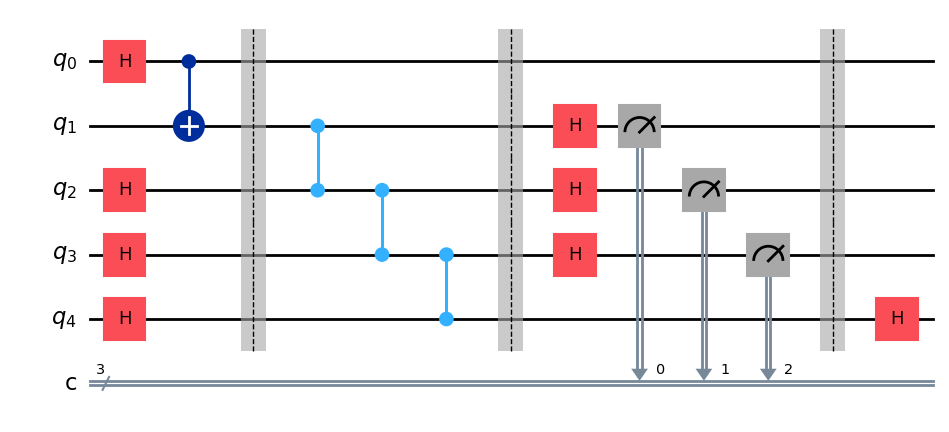

In [9]:
def build_visualization_circuit(num_qubits: int):
    """Construct the circuit for visualization purposes."""
    circ = QuantumCircuit(num_qubits, num_qubits - 2) # N-2 classical bits for intermediate measurements
    
    # 1. Initialization
    circ.h(0)
    circ.cx(0, 1)
    for q in range(2, num_qubits):
        circ.h(q)
    circ.barrier()
    
    # 2. CZ Chain
    for q in range(1, num_qubits - 1):
        circ.cz(q, q + 1)
    circ.barrier()
    
    # 3. Measurement (X basis)
    measure_qubits = range(1, num_qubits - 1)
    for idx, q in enumerate(measure_qubits):
        circ.h(q)
        circ.measure(q, idx)
    circ.barrier()
    
    # 4. Structural H gates (Simplified)
    target = num_qubits - 1
    num_measurements = len(measure_qubits)
    
    if num_measurements % 2 == 1:
        # Odd number -> One H
        circ.h(target)
    # Even number -> No gate (Identity)
        
    return circ

# Draw the circuit for N=5
circ_viz = build_visualization_circuit(5)
circ_viz.draw(output='mpl')


Chain length sensitivity (fixed noise):
  N=3: fidelity=0.960439
  N=4: fidelity=0.931692
  N=5: fidelity=0.905716
  N=6: fidelity=0.864531
  N=7: fidelity=0.863858
  N=8: fidelity=0.839129
  N=9: fidelity=0.802082


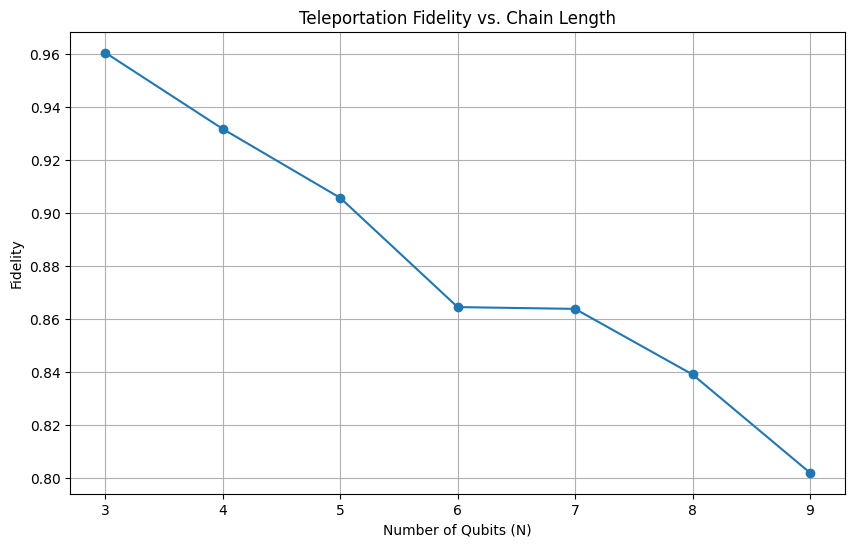

In [10]:
import matplotlib.pyplot as plt

print("\nChain length sensitivity (fixed noise):")
noise_model = build_noise_model(noise)

N_values = []
fidelities = []

# Sweep from 3 to 17
for n in range(3, 10):
    # Reuse the same noise model so differences stem purely from circuit depth
    ideal_sim = AerSimulator(method="density_matrix")
    noisy_sim = AerSimulator(method="density_matrix", noise_model=noise_model)
    
    # Reference Bell pair
    rho_ref = bell_pair_density(ideal_sim)
    
    # Custom simulation to avoid full-state save for large N
    circ = build_n_qubit_circuit(n)
    
    # Optimization: Remove the default full save_density_matrix
    if circ.data and circ.data[-1].operation.name == 'save_density_matrix':
        circ.data.pop()
        
    # Save only the entanglement pair (qubits 0 and n-1)
    circ.save_density_matrix(qubits=[0, n - 1], label="rho_pair")
    
    # Run simulation
    compiled = transpile(circ, noisy_sim)
    result = noisy_sim.run(compiled).result()
    
    # Retrieve the 2-qubit partial density matrix
    rho_noisy = DensityMatrix(result.data(0)["rho_pair"])
    
    fidelity = state_fidelity(rho_ref, rho_noisy)
    fidelities.append(fidelity)
    N_values.append(n)
    
    print(f"  N={n}: fidelity={fidelity:.6f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N_values, fidelities, marker='o', linestyle='-')
plt.title("Teleportation Fidelity vs. Chain Length")
plt.xlabel("Number of Qubits (N)")
plt.ylabel("Fidelity")
plt.grid(True)
plt.xticks(N_values)
plt.show()
